In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models import resnet50, ResNet50_Weights

from pycocotools.coco import COCO
import requests

In [2]:
# Paths to COCO dataset annotations and images
TRAIN_ANNOTATION_PATH = r'D:\Ryan\datasets\Pose\annotations_trainval2017\annotations\person_keypoints_train2017.json'
VAL_ANNOTATION_PATH = r'D:\Ryan\datasets\Pose\annotations_trainval2017\annotations\person_keypoints_val2017.json'
TRAIN_IMAGE_PATH = r'D:\Ryan\datasets\Pose\train2017\train2017'
VAL_IMAGE_PATH = r'D:\Ryan\datasets\Pose\val2017\val2017'

# Number of keypoints in COCO dataset
NUM_KEYPOINTS = 17

# Input and output image sizes
INPUT_SIZE = (192, 256)   # Width, Height
OUTPUT_SIZE = (64, 48)    # Height, Width (for heatmaps)

# Random seed for reproducibility
SEED = 42

In [3]:
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
class PersonKeypointsDataset(Dataset):
    def __init__(self, annotation_file, image_path, min_keypoints=9, max_samples=None, transform=None, target_transform=None, seed=SEED):
        """
        Custom Dataset for COCO Person Keypoints
        """
        self.coco = COCO(annotation_file)
        self.image_path = image_path
        self.transform = transform
        self.target_transform = target_transform
        self.person_ids = self.coco.getCatIds(catNms=['person'])
        self.img_ids = self.coco.getImgIds(catIds=self.person_ids)

        # Set seeds for reproducibility
        set_seed(seed)
        
        # Build list of (image_id, annotation) tuples
        self.samples = []
        for img_id in self.img_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.person_ids, iscrowd=False)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                # Include only samples with enough keypoints
                if 'keypoints' in ann and ann['num_keypoints'] >= min_keypoints:
                    self.samples.append((img_id, ann))

        # Randomly sample if we have more samples than max_samples
        if max_samples and max_samples < len(self.samples):
            self.samples = random.sample(self.samples, max_samples)
            print(f"Randomly sampled {len(self.samples)} images from {len(self.samples)} total images")
                        
    def __len__(self):
        """
        Returns the number of samples in the dataset
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Fetches the image and keypoints for the given index.
        """
        img_id, ann = self.samples[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_path, img_info['file_name'])
        if not os.path.exists(img_path):
            raise RuntimeError(f"Image file not foung: {img_path}")
        img = Image.open(img_path).convert("RGB")
        
        # Get bounding box
        bbox = ann['bbox']  # [x, y, w, h]
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        
        # Crop image to bounding box
        img = img.crop((x1, y1, x2, y2))
        
        orig_w, orig_h = img.size
        
        # Adjust keypoints
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)
        keypoints[:, 0] -= x1
        keypoints[:, 1] -= y1
        
        # Resize image and keypoints
        new_size = INPUT_SIZE  # (width, height)
        img = img.resize(new_size, resample=Image.BILINEAR)
        
        scale_x = new_size[0] / orig_w
        scale_y = new_size[1] / orig_h
        keypoints[:, 0] = (keypoints[:, 0] * scale_x)
        keypoints[:, 1] = (keypoints[:, 1] * scale_y)
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)
        
        # Generate heatmaps
        if self.target_transform:
            target = self.target_transform(keypoints)
        else:
            target = torch.tensor(keypoints, dtype=torch.float32)
        
        return img, target, keypoints

In [5]:
class HeatmapGenerator:
    """
    Generates heatmaps for each keypoint.
    Uses Gaussian distributions.
    """
    def __init__(self, output_size, num_keypoints, sigma=2):
        self.output_size = output_size  # (height, width)
        self.num_keypoints = num_keypoints
        self.sigma = sigma
        
    def __call__(self, keypoints):
        heatmaps = np.zeros((self.num_keypoints, self.output_size[0], self.output_size[1]), dtype=np.float32)
        tmp_size = self.sigma * 3

        for i in range(self.num_keypoints):
            kp = keypoints[i]
            x, y, v = kp
            if v > 0:
                x = x * self.output_size[1] / INPUT_SIZE[0]
                y = y * self.output_size[0] / INPUT_SIZE[1]
                
                ul = [int(x - tmp_size), int(y - tmp_size)]
                br = [int(x + tmp_size + 1), int(y + tmp_size + 1)]
                
                if ul[0] >= self.output_size[1] or ul[1] >= self.output_size[0] or br[0] < 0 or br[1] < 0:
                    continue
                
                size = 2 * tmp_size + 1
                x_coords = np.arange(0, size, 1, np.float32)
                y_coords = x_coords[:, np.newaxis]
                x0 = y0 = size // 2
                g = np.exp(- ((x_coords - x0) ** 2 + (y_coords - y0) ** 2) / (2 * self.sigma ** 2))
                
                g_x = max(0, -ul[0]), min(br[0], self.output_size[1]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], self.output_size[0]) - ul[1]
                
                img_x = max(0, ul[0]), min(br[0], self.output_size[1])
                img_y = max(0, ul[1]), min(br[1], self.output_size[0])
                
                heatmaps[i][img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
                
        return torch.tensor(heatmaps, dtype=torch.float32)

In [6]:
def visualize_sample(dataset, idx):
    """
    Visualizes the image with keypoints and connections.
    Prints the number of keypoints and edges drawn for the given image.
    """
    img, _, keypoints = dataset[idx]
    img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C

    plt.figure(figsize=(5, 7))
    plt.imshow(img)
    
    # Extract keypoint data
    x = keypoints[:, 0]
    y = keypoints[:, 1]
    v = keypoints[:, 2]

    # COCO keypoint connections
    skeleton = [
        [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
        [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
        [1, 3], [2, 4], [3, 5], [4, 6]
    ]
    
    # Count visible keypoints
    visible_keypoints = np.sum(v > 0)
    print(f"Image {idx}: Number of visible keypoints: {visible_keypoints}")

    # Draw limbs and count edges
    edge_count = 0
    for connection in skeleton:
        p1, p2 = connection
        if v[p1] > 0 and v[p2] > 0:  # Only connect visible keypoints
            plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)
            edge_count += 1

    print(f"Image {idx}: Number of edges drawn: {edge_count}")

    # Draw keypoints
    for i in range(len(x)):
        if v[i] > 0:
            plt.plot(x[i], y[i], 'bo', markersize=5)

    plt.axis('off')
    plt.show()

loading annotations into memory...
Done (t=7.88s)
creating index...
index created!
Randomly sampled 200 images from 200 total images
Image 0: Number of visible keypoints: 9
Image 0: Number of edges drawn: 9


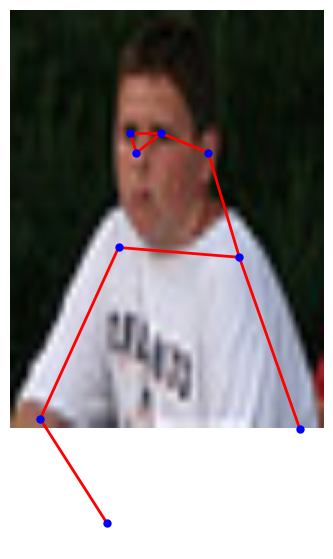

Image 1: Number of visible keypoints: 15
Image 1: Number of edges drawn: 15


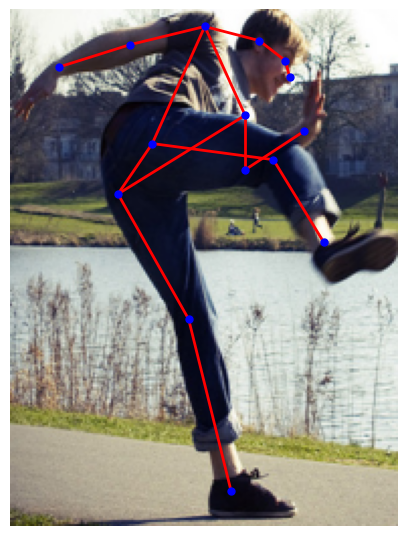

Image 2: Number of visible keypoints: 13
Image 2: Number of edges drawn: 15


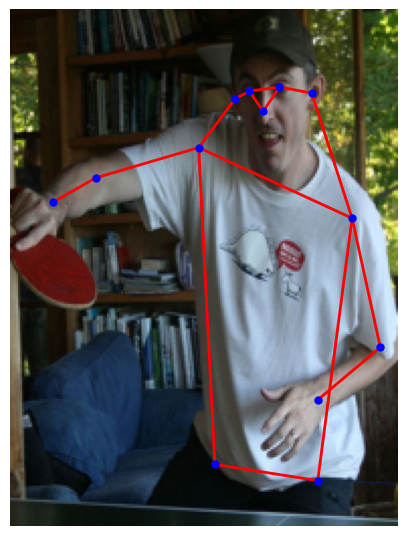

Image 3: Number of visible keypoints: 13
Image 3: Number of edges drawn: 13


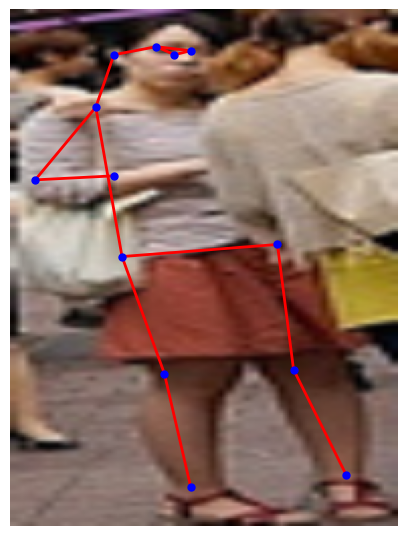

Image 4: Number of visible keypoints: 16
Image 4: Number of edges drawn: 17


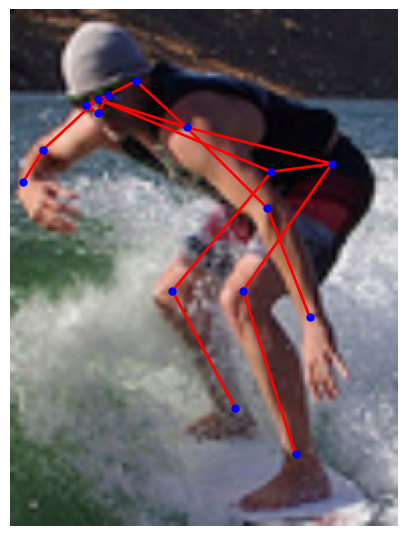

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize dataset
dataset_for_visual = PersonKeypointsDataset(
    annotation_file=TRAIN_ANNOTATION_PATH,
    image_path=TRAIN_IMAGE_PATH,
    min_keypoints=9,
    max_samples=200,
    transform=transform,
    target_transform=None  # no need to use heatmaps for visualization
)

# Visualize a few samples
for idx in range(5):
    visualize_sample(dataset_for_visual, idx)

In [8]:
def visualize_with_keypoints_and_heatmaps(dataset, idx, heatmap_generator):
    """
    Visualize the original image and overlay heatmap with keypoints and skeleton connections.
    """
    img, _, keypoints = dataset[idx]
    img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C for visualization

    # Generate heatmaps
    heatmaps = heatmap_generator(keypoints)
    heatmaps_np = heatmaps.numpy()
    combined_heatmap = np.sum(heatmaps_np, axis=0)

    # Extract keypoint data
    x = keypoints[:, 0]
    y = keypoints[:, 1]
    v = keypoints[:, 2]

    # COCO keypoint connections
    skeleton = [
        [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
        [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
        [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
        [1, 3], [2, 4], [3, 5], [4, 6]
    ]

    # Plot original image on the left
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Plot overlay heatmap with keypoints and skeleton on the right
    plt.subplot(1, 2, 2)
    plt.imshow(img, alpha=0.5)
    plt.imshow(combined_heatmap, cmap='hot', alpha=0.5)
    
    # Draw limbs
    for connection in skeleton:
        p1, p2 = connection
        if v[p1] > 0 and v[p2] > 0:  # Only connect visible keypoints
            plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)

    # Draw keypoints
    for i in range(len(x)):
        if v[i] > 0:
            plt.plot(x[i], y[i], 'bo', markersize=5)

    plt.title("Overlay Heatmap with Keypoints")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

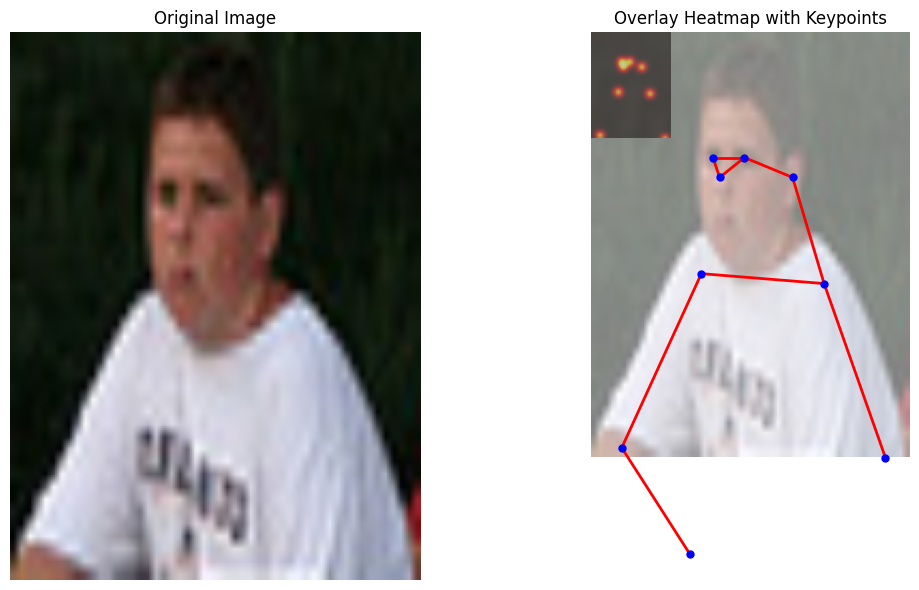

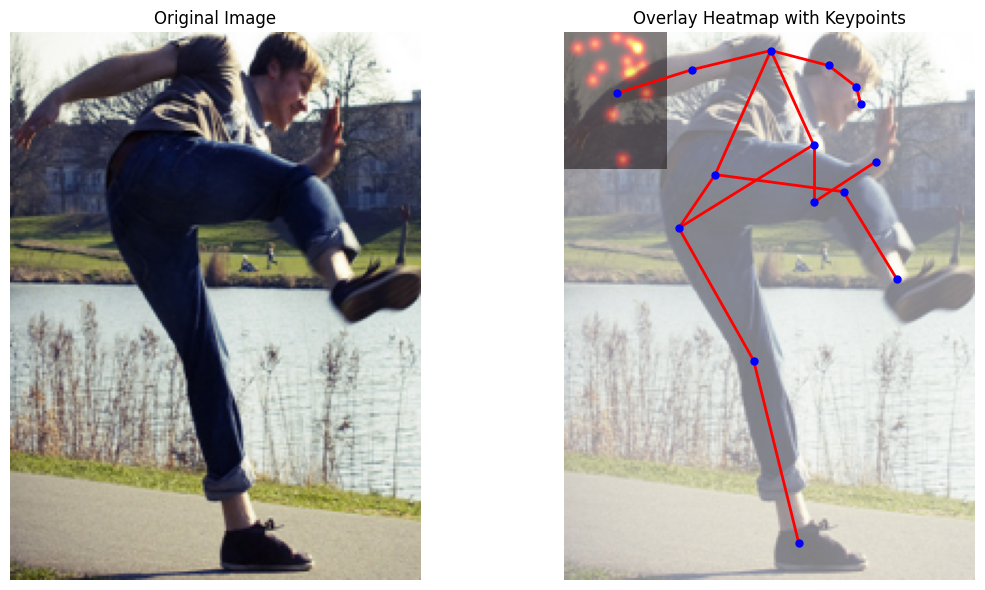

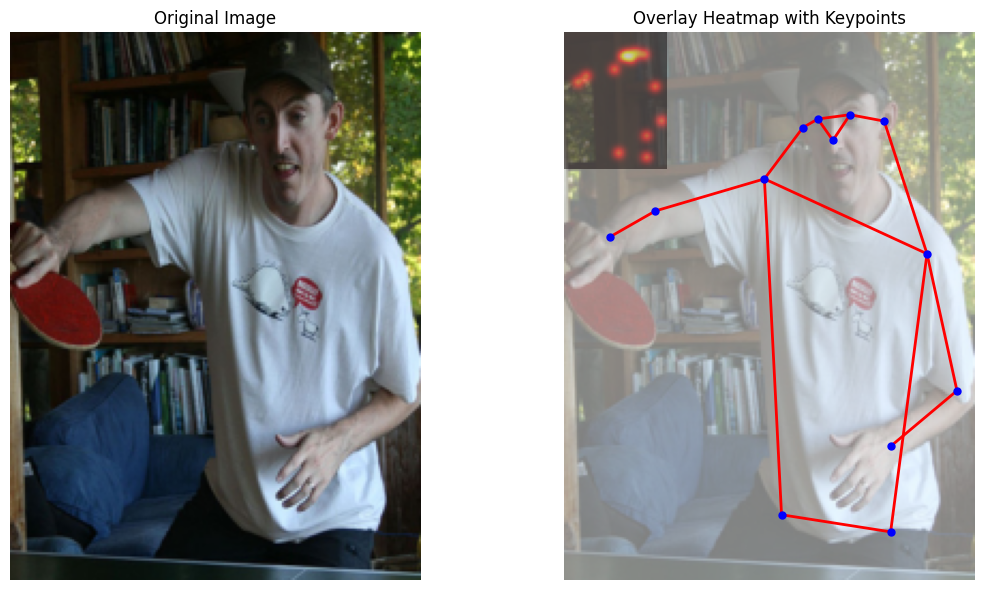

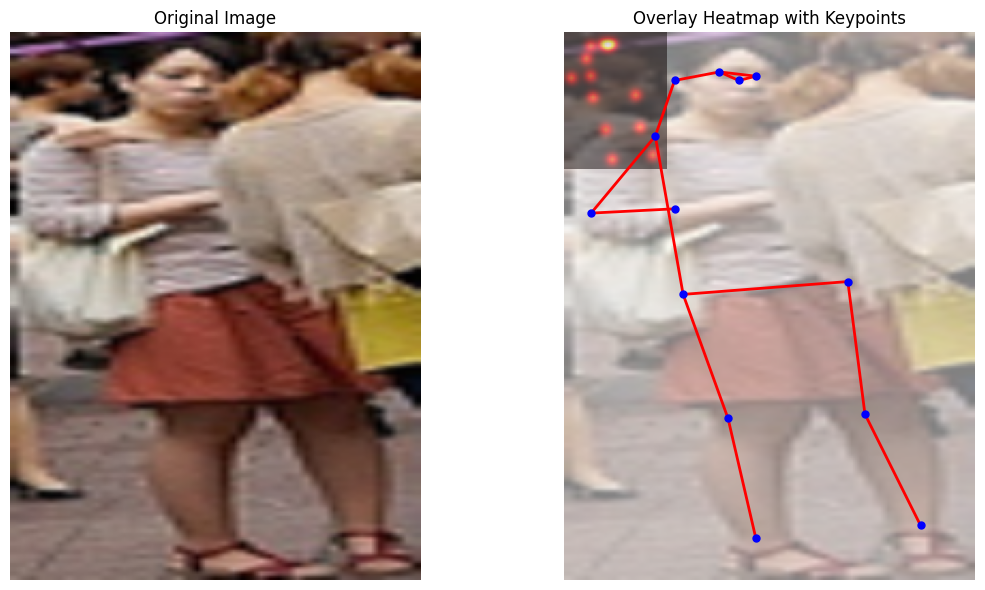

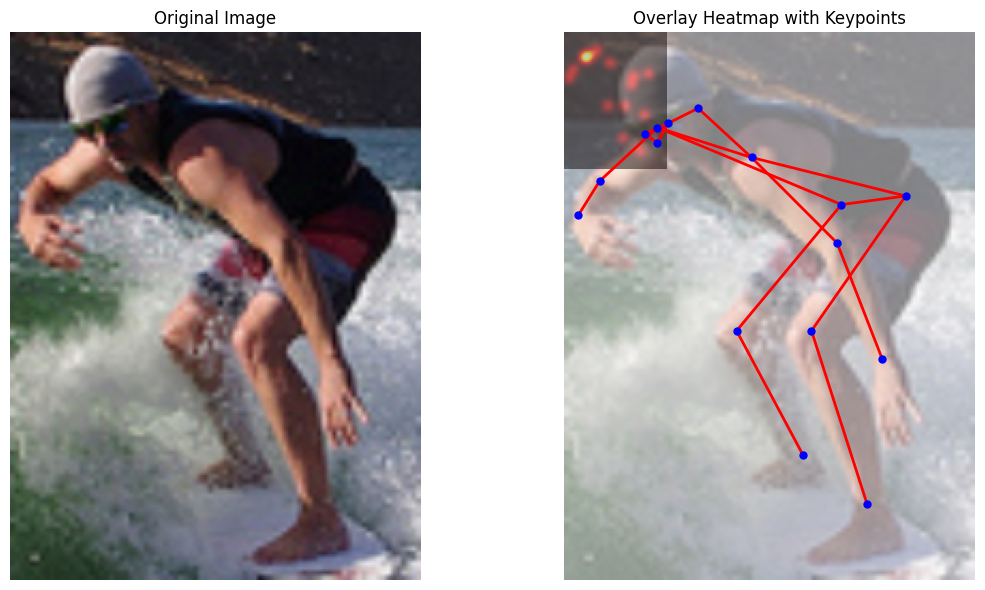

In [9]:
# Initialize Heatmap Generator
heatmap_generator = HeatmapGenerator(output_size=OUTPUT_SIZE, num_keypoints=NUM_KEYPOINTS)

# Visualize heatmaps and keypoints for a few samples
for idx in range(5):
    visualize_with_keypoints_and_heatmaps(dataset_for_visual, idx, heatmap_generator)

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class PoseNet(nn.Module):
    def __init__(self, num_keypoints):
        super(PoseNet, self).__init__()
        # Load pretrained ResNet50 as backbone
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Remove the last two layers (avgpool and fc)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Refinement stages
        self.stage1 = nn.Sequential(
            ConvBlock(2048, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256)
        )
        
        self.stage2 = nn.Sequential(
            ConvBlock(256, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128)
        )
        
        self.stage3 = nn.Sequential(
            ConvBlock(128, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64)
        )
        
        # Upsampling layers
        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        
        # Final layers for keypoint prediction
        self.final_stage = nn.Sequential(
            ConvBlock(64, 32),
            nn.Conv2d(32, num_keypoints, kernel_size=1)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Backbone feature extraction
        x = self.backbone(x)
        
        # Refinement stages with upsampling
        x = self.stage1(x)
        x = self.deconv1(x)
        
        x = self.stage2(x)
        x = self.deconv2(x)
        
        x = self.stage3(x)
        x = self.deconv3(x)
        
        # Final prediction
        x = self.final_stage(x)
        
        return x

In [11]:
# Re-initialize dataset with target_transform (heatmaps)
target_transform = HeatmapGenerator(output_size=OUTPUT_SIZE, num_keypoints=NUM_KEYPOINTS)

dataset = PersonKeypointsDataset(
    annotation_file=TRAIN_ANNOTATION_PATH,
    image_path=TRAIN_IMAGE_PATH,
    min_keypoints=9,
    max_samples=None,
    transform=transform,
    target_transform=target_transform
)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

loading annotations into memory...
Done (t=6.71s)
creating index...
index created!
Training samples: 86755
Validation samples: 21689


In [12]:
BATCH_SIZE = 16  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = PoseNet(num_keypoints=NUM_KEYPOINTS).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [14]:
import time
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    start_time = time.time()

    # Training loop
    for images, targets, _ in train_loader:
        images = images.to(device)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, targets, _ in val_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # Mixed precision validation: forward pass
            if device.type == 'cuda':
                with autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(images)
                loss = criterion(outputs, targets)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Time: {elapsed_time:.2f}s")

    torch.save(model.state_dict(), f'PoseNet_model_epoch_{epoch}_loss_{avg_val_loss}.pth')

Epoch [1/100], Train Loss: 0.0095, Validation Loss: 0.0147, Time: 2185.41s
Epoch [2/100], Train Loss: 0.0030, Validation Loss: 0.0381, Time: 1024.41s
Epoch [3/100], Train Loss: 0.0027, Validation Loss: 0.0028, Time: 806.97s
Epoch [4/100], Train Loss: 0.0023, Validation Loss: 0.0022, Time: 1156.01s
Epoch [5/100], Train Loss: 0.0020, Validation Loss: 0.0019, Time: 1351.13s
Epoch [6/100], Train Loss: 0.0018, Validation Loss: 0.0018, Time: 1311.23s
Epoch [7/100], Train Loss: 0.0017, Validation Loss: 0.0017, Time: 1321.37s
Epoch [8/100], Train Loss: 0.0015, Validation Loss: 0.0018, Time: 1324.66s
Epoch [9/100], Train Loss: 0.0014, Validation Loss: 0.0016, Time: 1296.68s
Epoch [10/100], Train Loss: 0.0014, Validation Loss: 0.0017, Time: 1163.44s
Epoch [11/100], Train Loss: 0.0013, Validation Loss: 0.0016, Time: 1104.33s
Epoch [12/100], Train Loss: 0.0012, Validation Loss: 0.0016, Time: 1314.78s
Epoch [13/100], Train Loss: 0.0011, Validation Loss: 0.0016, Time: 1459.06s
Epoch [14/100], Train 

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(train_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [44]:
def visualize_results(model, dataset, idx):
    model.eval()
    with torch.no_grad():
        img, _, keypoints = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        outputs = model(img_tensor)
        output_heatmaps = outputs.squeeze(0).cpu()
        
        # Get predicted keypoints from heatmaps
        pred_keypoints = []
        for i in range(NUM_KEYPOINTS):
            heatmap = output_heatmaps[i]
            y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)
            confidence = heatmap.max()
            pred_x = (x / OUTPUT_SIZE[1]) * INPUT_SIZE[0]
            pred_y = (y / OUTPUT_SIZE[0]) * INPUT_SIZE[1]
            pred_keypoints.append((pred_x, pred_y, confidence))
        pred_keypoints = np.array(pred_keypoints)
        
        # Visualize Ground Truth
        img_np = img.permute(1, 2, 0).numpy()
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        x = keypoints[:, 0]
        y = keypoints[:, 1]
        v = keypoints[:, 2]

        # Draw ground truth skeleton
        for connection in skeleton:
            p1, p2 = connection
            if v[p1] > 0 and v[p2] > 0:
                plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'r-', linewidth=2)
        for i in range(len(x)):
            if v[i] > 0:
                plt.plot(x[i], y[i], 'bo', markersize=5)
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Visualize Prediction
        plt.subplot(1, 2, 2)
        plt.imshow(img_np)
        x = pred_keypoints[:, 0]
        y = pred_keypoints[:, 1]
        c = pred_keypoints[:, 2]

        # Draw predicted skeleton
        for connection in skeleton:
            p1, p2 = connection
            if c[p1] > 0.1 and c[p2] > 0.1:  # Threshold confidence
                plt.plot([x[p1], x[p2]], [y[p1], y[p2]], 'g-', linewidth=2)
        for i in range(len(x)):
            if c[i] > 0.1:
                plt.plot(x[i], y[i], 'yo', markersize=5)
        plt.title('Model Prediction')
        plt.axis('off')
        
        plt.show()

C:\Users\rmcgove3\AppData\Local\Temp\ipykernel_10416\2669036051.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y, x = np.unravel_index(heatmap.argmax(), heatmap.shape)


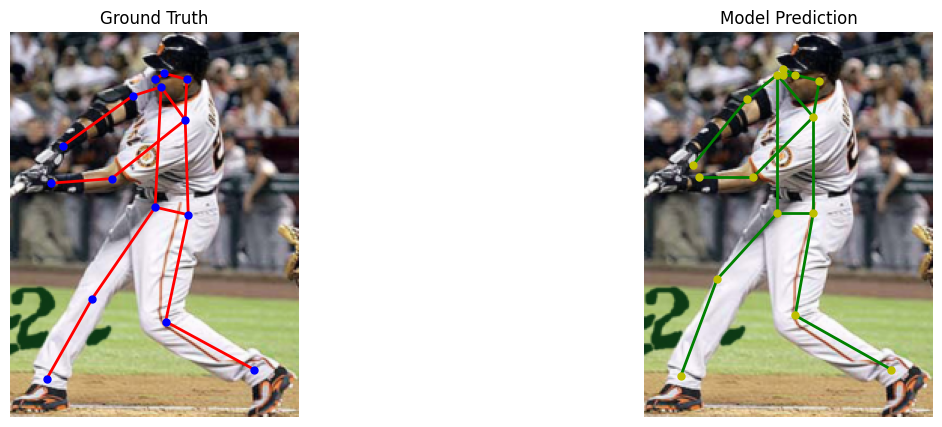

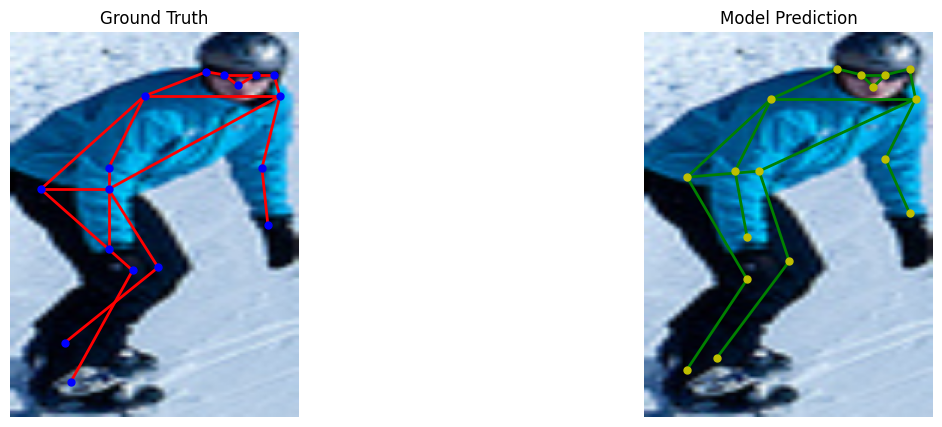

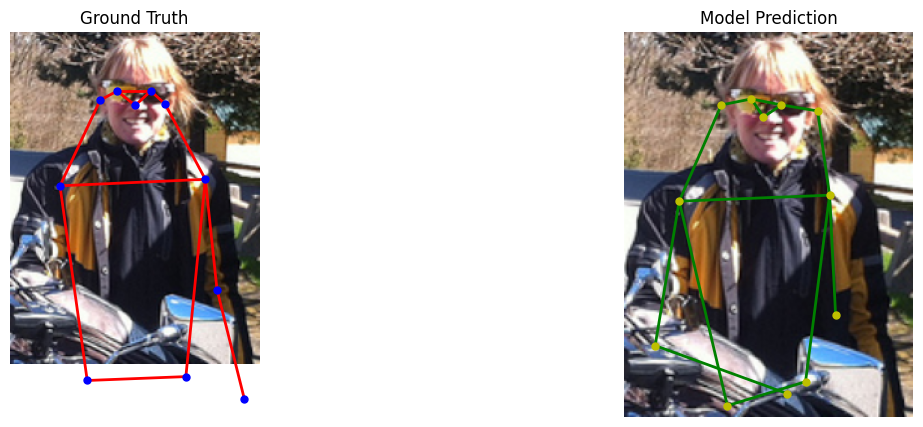

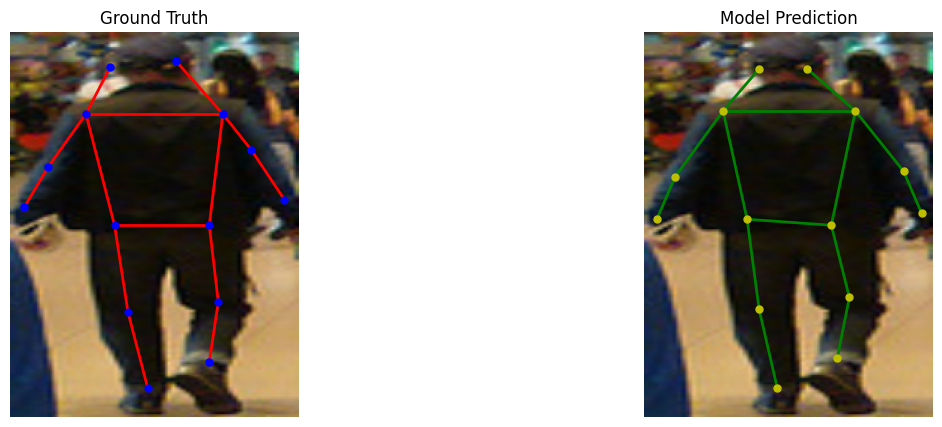

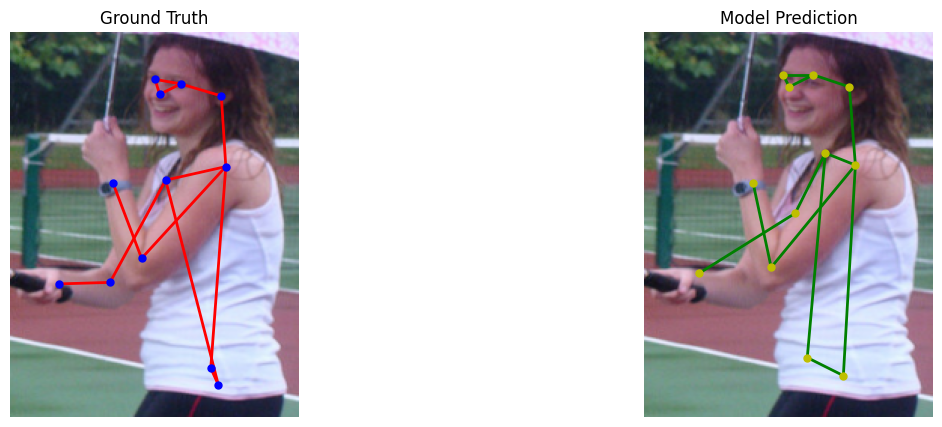

In [45]:
# COCO keypoint connections
skeleton = [
    [15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
    [5, 11], [6, 12], [5, 6], [5, 7], [6, 8],
    [7, 9], [8, 10], [1, 2], [0, 1], [0, 2],
    [1, 3], [2, 4], [3, 5], [4, 6]
]

# Visualize results on validation data
for i in range(5):
    visualize_results(model, val_dataset, i)

In [47]:
# Save the trained model
torch.save(model.state_dict(), 'models/PoseNet_model.pth')

RuntimeError: Parent directory models does not exist.

In [ ]:
# Load the test dataset
test_dataset = PersonKeypointsDataset(
    annotation_file=VAL_ANNOTATION_PATH,
    image_path=VAL_IMAGE_PATH,
    min_keypoints=9,
    max_samples=150,
    transform=transform,
    target_transform=target_transform
)
print(f"Test samples: {len(test_dataset)}")

# Load the model
model.load_state_dict(torch.load('posenet_model.pth'))

# Visualize results on test data
for i in range(5):
    visualize_results(model, test_dataset, i)